## Motivation

## Methods and Results

Profiles of games on the iTunes App Store (https://apps.apple.com/us/genre/ios-games/id6014) were scraped using the python package Scrapy. Game profiles were stored in a SQLite database, in a table named after the genre section they were scrapped from. Note that a game can appear in multiple genre sections. The web scraping code may be found in [].

In [ ]:
# Autoreload to accomodate script updates without restarting notebook
%load_ext autoreload
%autoreload 2
# Move to main directory of the Customer-Segmentation project
%cd ..

In [2]:
import pandas as pd
import sqlalchemy as sa
from pathlib import Path

# Pull interim data from SQLite DB

DB_NAME = 'app-store'
e = sa.create_engine('sqlite:///./data/interim/app-store.sqlite')
query = '''
        SELECT *, 'action' AS genre FROM iosaction UNION
        SELECT *, 'adventure' FROM iosadventure UNION
        SELECT *, 'board' FROM iosboard UNION
        SELECT *, 'card' FROM ioscard UNION 
        SELECT *, 'casino' FROM ioscasino UNION
        SELECT *, 'casual' FROM ioscasual UNION
        SELECT *, 'family' FROM iosfamily UNION
        SELECT *, 'music' FROM iosmusic UNION
        SELECT *, 'puzzle' FROM iospuzzle UNION
        SELECT *, 'racing' FROM iosracing UNION
        SELECT *, 'rpg' FROM iosrpg UNION
        SELECT *, 'simulation' FROM iossimulation UNION
        SELECT *, 'sports' FROM iossports UNION 
        SELECT *, 'strategy'FROM iosstrategy UNION 
        SELECT *, 'trivia' FROM iostrivia UNION
        SELECT *, 'word' FROM iosword
        '''
apps = pd.read_sql_query(query, e)

Loading the data, it is apparent that the data needs be cleaned. Each field is populated by strings, and not all entries were available for each game profile. A sample of the raw data is shown below. 

In [513]:
apps.head()
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25593 entries, 2 to 195701
Data columns (total 57 columns):
title                       25593 non-null object
author                      25593 non-null object
compat                      25593 non-null float64
editor                      25593 non-null int64
iap                         25593 non-null int64
list_rank                   25593 non-null int64
nrating                     25593 non-null float64
price                       25593 non-null float64
score                       25593 non-null float64
size                        25593 non-null float64
age_12                      25593 non-null int64
age_17                      25593 non-null int64
age_4                       25593 non-null int64
age_9                       25593 non-null int64
gen_action                  25593 non-null int64
gen_adventure               25593 non-null int64
gen_board                   25593 non-null int64
gen_card                    25593 non-null in

### Data cleaning

Each feature is defined and described in the code cell below, as well as the processing required to organize the raw data into continuous and categorical variables. Cleaning can take some time, to the formatted data set is saved into a database at the end of the code cell.

In [4]:
import re
import numpy as np

# age (categorical)
# Age rating for game. Dummy encoded.
# Categories are 4+, 9+, 12+, 17+

age_encoded = pd.get_dummies(apps['age'])
age_encoded.columns = ['age_' + col.replace('+','') for col in age_encoded.columns]
apps = pd.concat([apps, age_encoded], axis=1)
apps = apps.drop(columns=['age'])

# age_copy (str)
# Long string containing a variety information, including age rating, memory size, copyright information. 
# Was initially scraped to get the copyright year, to give estimate of release date. 
# Copyright year is not included frequently enough, however, so this category was dropped

apps = apps.drop(columns=['age_copy'])

# author (str)
# Author of game. Can be used to consolidate duplicate game titles

# category (categorical)
# Category of app. Data was scrapped from game storefront, so everything should be listed as 'Games'
# There are a few cases where this was not true (e.g. classified as 'Education', or 'Music')
# Only concerned with game releases, so we filter for these specifically

apps = apps[apps['category'] == 'Games']
apps = apps.drop(columns=['category'])

# compat (ordinal)
# Compatibility of the app. Interested primarily in the minimum OS release requirements. 
# There are 409 different OS version releases (including minor releases), so we confine our search to major software versions

# Very few cases don't contain compatibility information; filter these out
apps = apps.dropna(subset=['compat']) 
# All version requirements starts with the phrase, 'Requires iOS x.x. or later'. First filter for that phrase
apps['compat'] = apps['compat'].apply(lambda compat: re.findall(r'Requires\siOS\s\d+', compat)) 
# Pull out just the major iOS release version. 
apps['compat'] = apps['compat'].apply(lambda compat: int(re.findall(r'\d+', compat[0])[0]) if compat else None)
# Also filter out apps that are not on iOS (few Apple TV apps)
apps = apps.dropna(subset=['compat']) 

# desc (str)
# Description of app. May be interesting to analyze for keywords in the future.
# Out-of-scope for this analysis, so it's dropped

apps = apps.drop(columns=['desc'])

# editor (boolean)
# Indicates whether the game was notable enough to receive an 'Editor's Choice' or 'Editor's Note' designation
# These recognized games are on the front page most often, and the App Store will promote these apps particularly

apps['editor'] = apps['editor'].apply(lambda editor: True if editor else False)

# genre (categorical)
# Genre of game, based on the page on which the title was scrapped from. Dummy encoded
# Note that games can be a part of multiple genres
# This was assigned in the SQL code a previous cell. 

genre_encoded = pd.get_dummies(apps['genre'])
genre_encoded.columns = ['gen_' + col.lower() for col in genre_encoded.columns]
apps = pd.concat([apps, genre_encoded], axis=1)
apps = apps.drop(columns=['genre'])

# iap (boolean)
# Indicates whether the game contains in-app purchases

apps['iap'] = apps['iap'].replace('Offers In-App Purchases', True).fillna(False)

# lang (categorical)
# Languages the game is available in. Dummy encoded
# Hyperparameter 'thresh' limits the number of language categories based on popularity

# new category counts number of languages the game is available in
apps['lang_cnt'] = apps['lang'].apply(lambda lang: len(lang.split(', ')))

lang_encoded = apps['lang'].str.get_dummies(', ')
thresh = 0.05 * len(apps)
thresh_list = (lang_encoded.sum(axis=0) < thresh).to_list()
ind_drop = np.where(thresh_list)
lang_encoded = lang_encoded.drop(lang_encoded.columns[ind_drop], axis=1)
lang_encoded.columns = ['lang_' + col.replace(' ','_').lower() for col in lang_encoded.columns]

apps = pd.concat([apps, lang_encoded], axis=1)
apps = apps.drop(columns=['lang'])

# list_rank (boolean)
# Typically the rank of the game within a given category (assuming the game is ranked)
# Field is not strictly limited to rank: it can also contain hardware restrictions ('Only for Apple TV'). 
# Anticipated release dates can also be found in this field.
# Initially seemed like a promising predictive feature, but upon inspection of the data, the ranking system is not consistent.
# Games can appear in different genre pages, and be ranked in other genres. Value of rank is inconsistent as well.
# Due to the inconsistency of this metric, it was simplified into a boolean: ranked, or not

apps['list_rank'] = apps['list_rank'].fillna('').apply(lambda rank: True if re.findall(r'#', rank) else False)

# nrating (numeric)
# Number ratings the game received

apps['nrating'] = apps['nrating'].fillna('0.0') # account for games that haven't been rated
# In raw form, if the review count is over a thousand or a million, the abbreviation 'K' or 'M' is used
apps['in_K'] = apps['nrating'].apply(lambda nrating: True if re.findall(r'K', nrating) else False)
apps['in_M'] = apps['nrating'].apply(lambda nrating: True if re.findall(r'M', nrating) else False)
apps['nrating'] = apps['nrating'].apply(lambda nrating: float(re.findall(r'[\d\.]+', nrating)[0]))
apps['nrating'] = apps.apply(lambda app: 1e3*app['nrating'] 
                             if app['in_K'] == True 
                             else app['nrating'], axis=1)
apps['nrating'] = apps.apply(lambda app: 1e6*app['nrating'] 
                             if app['in_M'] == True 
                             else app['nrating'], axis=1)
apps = apps.drop(columns=['in_K', 'in_M'])

# price (numeric)
# Price of game

# we also drop a few cases (73) where a price wasn't listed
apps = apps.dropna(subset=['price'])
apps['price'] = apps['price'].apply(lambda price: float(re.findall(r'[\d\.]+', price)[0]) 
                                    if price != 'Free' 
                                    else 0.0)

# score (numeric)
# Mean score across all ratings. Games that have not been rated will have a NaN assigned in this field

apps['score'] = apps['score'].fillna(np.nan).apply(float)

# seller (str)
# Party that sells the game, usually same as author. Dropped in this project

apps = apps.drop(columns=['seller'])

# size (float)
# Size of game, in MB. Games that are in KB are rounded to 1.0 MB

apps['in_KB'] = apps['size'].apply(lambda nrating: True if re.findall(r'KB', nrating) else False)
apps['in_GB'] = apps['size'].apply(lambda nrating: True if re.findall(r'GB', nrating) else False)
apps['size'] = apps['size'].apply(lambda nrating: float(re.findall(r'[\d\.]+', nrating)[0]))
apps['size'] = apps.apply(lambda app: 1.0
                             if app['in_KB'] == True 
                             else app['size'], axis=1)
apps['size'] = apps.apply(lambda app: 1e3*app['size'] 
                             if app['in_GB'] == True 
                             else app['size'], axis=1)
apps = apps.drop(columns=['in_KB', 'in_GB'])

# stars (numerical)
# Rating breakdown for the game
# Split into multiple categories, one for each possible rating

apps['stars'] = apps['stars'].apply(lambda rating: re.findall(r'\d+', rating)
                                    if rating is not None 
                                    else [0, 0, 0, 0, 0])
apps['star5'] = apps['stars'].apply(lambda rating: float(rating[0]))
apps['star4'] = apps['stars'].apply(lambda rating: float(rating[1]))
apps['star3'] = apps['stars'].apply(lambda rating: float(rating[2]))
apps['star2'] = apps['stars'].apply(lambda rating: float(rating[3]))
apps['star1'] = apps['stars'].apply(lambda rating: float(rating[4]))
apps = apps.drop(columns=['stars'])

# subtitle (str)
# Subtitle of game, if it exists. 
# Could be useful in the future of keyword analysis, but dropped for now

apps = apps.drop(columns=['subtitle'])

# support (categorical)
# iOS supports features such as 'Family Center' and 'Game Center' which can augment a user's experience

# one-hot enocde supports category
supports_encoded = apps['support'].str.get_dummies(',')
supports_encoded.columns = ['sup_' + col.replace(' ','_').lower() for col in supports_encoded.columns]
apps = pd.concat([apps, supports_encoded], axis=1)
apps = apps.drop(columns=['support'])

# title (str)
# Title of game
# Games can be scrapped multiple times since they can be posted on multiple genre pages
# Title can be used to consolidate these duplicates

def agg_func(x):
    '''Dictate the aggregate function to apply based on the data object type

    param x: DataFrame groupby object
    '''
    if x.dtype in ('float64', 'object'):
        return x.mean()
    elif x.dtype in ('bool', 'uint8', 'int64'):
        return x.max()
    else:
        print('Unrecognized dtype!')

# Duplicate game titles can contain different rating and star values. These are will be averaged
# Boolean and integer values are dummy categories, so we mark as True/1 if so in at least one row
apps = apps.groupby(['title','author']).agg(agg_func).reset_index()


# Once date has been cleaned, we can save the data set to a DB
e = sa.create_engine('sqlite:///./data/interim/app-store.sqlite')
apps.to_sql('iosformatted', e, if_exists='replace', index=False)

### Preliminary inspection of data

Summary of the formatted data shows that, except for the title and author of the game, each feature has been transformed into a continuous variable (dtype=float64) or a dummy-encoded categorical variable (dtype=int64). Furthermore, the missing values have been accounted for or filled in. Note 

In [578]:
e = sa.create_engine('sqlite:///./data/interim/app-store.sqlite')
apps = pd.read_sql_query('SELECT * FROM iosformatted', e)
apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195732 entries, 0 to 195731
Data columns (total 56 columns):
title                       195732 non-null object
author                      195732 non-null object
compat                      195732 non-null float64
editor                      195732 non-null int64
iap                         195732 non-null int64
list_rank                   195732 non-null int64
nrating                     195732 non-null float64
price                       195732 non-null float64
score                       119988 non-null float64
size                        195732 non-null float64
age_12                      195732 non-null int64
age_17                      195732 non-null int64
age_4                       195732 non-null int64
age_9                       195732 non-null int64
gen_action                  195732 non-null int64
gen_adventure               195732 non-null int64
gen_board                   195732 non-null int64
gen_card                   

Data is heavily skewed, which will be a problem down the line. Most games are far from successful!

count    1.957320e+05
mean     6.533230e+02
std      1.787270e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      8.000000e+00
max      4.500000e+06
Name: nrating, dtype: float64

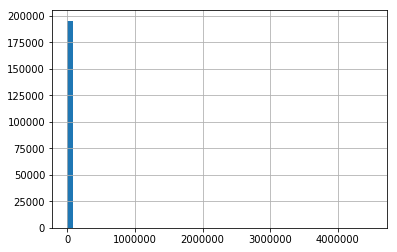

In [579]:
apps['nrating'].hist(bins=50)
apps['nrating'].describe()

CUt down the data set. Shadows has 175 reviews; lets aim for that at 50%

In [580]:
apps[apps['title']=='Where Shadows Slumber'][['title','nrating']]

,title,nrating
187663,Where Shadows Slumber,175.0


In [581]:
apps = apps[apps['nrating']>36]
apps['nrating'].describe()

count    2.559300e+04
mean     4.974343e+03
std      4.920964e+04
min      3.650000e+01
25%      7.100000e+01
50%      1.760000e+02
75%      7.255000e+02
max      4.500000e+06
Name: nrating, dtype: float64

In [582]:
bins = [36, 100, 1000, 10000, np.inf]
labels=[1, 2, 3, 4]
apps['nrating_cut'] = pd.cut(apps['nrating'], bins=bins, labels=labels)
apps['nrating_cut'].value_counts() / len(apps)

2    0.440706
1    0.355332
3    0.148986
4    0.054976
Name: nrating_cut, dtype: float64

In [583]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_ind, test_ind in split.split(apps, apps['nrating_cut']):
    train_set, test_set = apps.iloc[train_ind], apps.iloc[test_ind]

test_set['nrating_cut'].value_counts() / len(test_set)

2    0.440711
1    0.355343
3    0.149053
4    0.054894
Name: nrating_cut, dtype: float64

In [584]:
train_set[['title','author']].describe()

,title,author
count,20474,20474
unique,20459,7960
top,Mannequin Challenge,"Big Fish Games, Inc"
freq,2,238


In [585]:


e = sa.create_engine('sqlite:///./data/processed/app-store.sqlite')
test_set.to_sql('test_set', e, if_exists='replace')
train_set.to_sql('train_set', e, if_exists='replace')

In [586]:
test_label = test_set['nrating'].copy()
test_identity = test_set[['title','author']].copy()
test_set = test_set.drop(columns=['nrating_cut','nrating','title','author'])

train_label = train_set['nrating'].copy()
train_identity = train_set[['title','author']].copy()
train_set = train_set.drop(columns=['nrating_cut','nrating','title','author'])

In [568]:

train_label = train_set['nrating'].copy()
train_set = train_set.drop(columns='nrating')

numeric_feat = train_set.dtypes[train_set.dtypes == 'float64'].index



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000756283C8>,
      dtype=object)

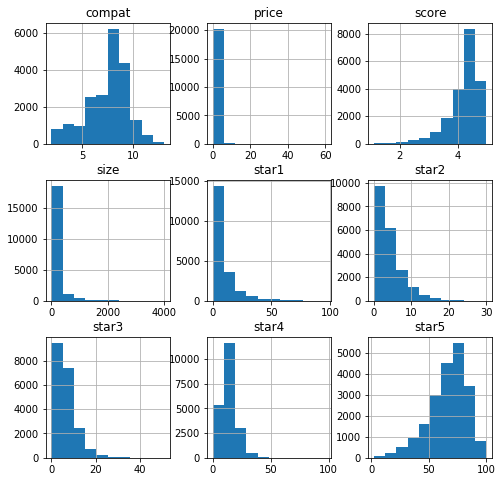

In [497]:
train_set[numeric_feat].hist(bins=10, figsize=(8,8))

In [479]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import skew
from scipy.stats import boxcox


class SkewCorrector(BaseEstimator, TransformerMixin):
    
    def __init__(self, skew_bound=0.2): # skew_bound is amount of skew that is acceptable
        self.skew_bound = skew_bound
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_val = X.to_numpy()
        
        # different distributions require different transforms; indicies are defined below for specific data types
        ind_skewed = np.absolute(skew(X_val)) > self.skew_bound
        ind_right_skew = skew(X_val) > 0
        ind_left_skew = skew(X_val) < 0
        ind_no_zeros = [0 not in X_val[:,col] for col in np.arange(X_val.shape[1])]
        ind_has_zeros = [0 in X_val[:,col] for col in np.arange(X_val.shape[1])]
        # if all elements in a feature column are positive, the sum of all those should be equal to the number of rows in that feature matrix
        ind_positive = [np.sign(X_val[:,col]).sum() == X_val.shape[0] for col in np.arange(X_val.shape[1])]

        # transform right and left skewed data that does not include zero values with boxcox
        X_trans, _ = np.apply_along_axis(boxcox, 0, X_val[:,ind_skewed & ind_no_zeros & ind_positive]) # returns list of arrays
        X_val[:,ind_skewed & ind_no_zeros & ind_positive] = np.vstack(X_trans).T
        
        # transform right skewed data that contains zero values with log plus one
        X_trans = np.log1p(X_val[:,ind_skewed & ind_right_skew & ind_has_zeros])
        X_val[:,ind_skewed * ind_right_skew * ind_has_zeros] = X_trans
        
        # transform left skewed data that contains zero values by increasing power incrementally
        for pwr in range(2, 5): #arbitarily set the power limit to 5; maybe make this a user-defined parameter?
            X_trans = X_val[:,ind_skewed * ind_left_skew * ind_has_zeros]**pwr
            if skew(X_trans) < self.skew_bound:
                break
        
        X_val[:,ind_skewed * ind_left_skew * ind_has_zeros] = X_trans
        
        # Update the input data frame with transformed values
        X_out = pd.DataFrame(X_val, index=X.index, columns=X.columns)
        return X_out
        
        

In [486]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('trans_skew', SkewCorrector(skew_bound=0.2)),
    ('std_scaler', StandardScaler())
])

numeric_feat = train_set.dtypes[train_set.dtypes == 'float64'].index
cat_feat = train_set.dtypes[train_set.dtypes != 'float64'].index


full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numeric_feat)
])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000005A2415C0>,
      dtype=object)

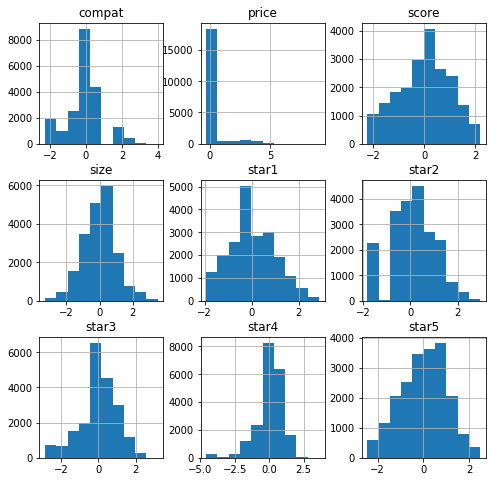

In [496]:
train_set_processed = train_set.copy()

train_set_processed[numeric_feat] = full_pipeline.fit_transform(train_set[numeric_feat])
train_set_processed[numeric_feat].hist(bins=10, figsize=(8,8))

Once the processing pipeline is complete, the training data can now be fitted. A number of different models were tried, mostly using the default hyperparameters. 

The following regressors were evaluated: linear regression, elastic net, stochastic gradient descent, linear support vector, k-nearest neighbor, random forest, and gradient tree boosting. 

In [20]:
from sklearn.model_selection import cross_val_score

def show_cv_result(scores):
    '''Print mean and standard deviation of an array of cross validation scores'''
    print(f'Cross validation mean score is : {np.mean(scores)} ± {np.std(scores)}')

In [500]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(train_set_processed, train_label)

scores = cross_val_score(reg, train_set_processed, train_label, scoring='neg_mean_absolute_error', cv=10)
show_cv_result(-scores)

Cross validation mean score is : 8936.187354307613 ± 386.89372868964784


In [501]:
from sklearn.linear_model import ElasticNet

reg = ElasticNet()
reg.fit(train_set_processed, train_label)

scores = cross_val_score(reg, train_set_processed, train_label, scoring='neg_mean_absolute_error', cv=10)
show_cv_result(-scores)

Cross validation mean score is : 7605.436540629622 ± 471.15271783392114


In [503]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor(loss='huber',max_iter=1000, tol=1e-3)
reg.fit(train_set_processed, train_label)

scores = cross_val_score(reg, train_set_processed, train_label, scoring='neg_mean_absolute_error', cv=10)
show_cv_result(-scores)

Cross validation mean score is : 4559.014655659934 ± 663.0066933862485


In [505]:
from sklearn.svm import LinearSVR

reg = LinearSVR()
reg.fit(train_set_processed, train_label)

scores = cross_val_score(reg, train_set_processed, train_label, scoring='neg_mean_absolute_error', cv=10)
show_cv_result(-scores)

Cross validation mean score is : 4521.5175046609165 ± 660.8778698301672


In [506]:
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor()
reg.fit(train_set_processed, train_label)

scores = cross_val_score(reg, train_set_processed, train_label, scoring='neg_mean_absolute_error', cv=10)
show_cv_result(-scores)

Cross validation mean score is : 6146.97995669237 ± 441.870128251233


Since random forest and gradient tree boosting both rely on decision trees (non-parametric), there is no need to standardize the input data, or correct for skew. 

In [507]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=100)
reg.fit(train_set, train_label)

scores = cross_val_score(reg, train_set, train_label, scoring='neg_mean_absolute_error', cv=10)
show_cv_result(-scores)

Cross validation mean score is : 5829.337069163397 ± 383.14539686508374


In [652]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(loss='huber')
reg.fit(train_set, train_label)

scores = cross_val_score(reg, train_set, train_label, scoring='neg_mean_absolute_error', cv=10)
show_cv_result(-scores)

Cross validation mean score is : 4296.625103862308 ± 623.1070420393522


With the lowest MAE, the best models to optimize further are stochastic gradient descent regression, linear support vector regression, and gradient boosted regression trees.  A grid search was performed to find the optimal hyperparameters. 

In [510]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'penalty': ['none', 'elasticnet'],
        'loss': ['huber', 'epsilon_insensitive'],
        'alpha': [1, 0.1, 1e-2, 1e-3, 1e-4],
        'learning_rate': ['invscaling', 'adaptive']
    }
]

reg = SGDRegressor(max_iter=2000, tol=1e-3, early_stopping=True)

sgd_grid = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)
sgd_grid.fit(train_set_processed, train_label)
-sgd_grid.best_score_

4544.319789206268

In [511]:
param_grid = [
    {
        'epsilon': [0, .1, 1, 10, 100],
        'C': [1, 10, 100, 1000]
    }
]

reg = LinearSVR(max_iter=10000)

svr_grid = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)
svr_grid.fit(train_set_processed, train_label)
-svr_grid.best_score_

4507.641075104035

In [631]:
param_grid = [
    {
        'max_depth': [3, 9],
        'learning_rate': [0.01, 0.1, 1],
        'loss' : ['huber', 'lad']
    }
]

reg = GradientBoostingRegressor()

gbr_grid = GridSearchCV(reg, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)
gbr_grid.fit(train_set, train_label)
-gbr_grid.best_score_

4166.171120076264

In [633]:
sgd_predict = sgd_grid.best_estimator_.predict(train_set_processed)
svr_predict = svr_grid.best_estimator_.predict(train_set_processed)
gbr_predict = gbr_grid.best_estimator_.predict(train_set)



In [643]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(train_label, gbr_predict)

4009.363581592267

In [640]:
train_label

160623        65.0
166999        56.0
45625       4700.0
62876        536.0
186893        45.0
2070         314.0
67425        101.0
119446      1100.0
130642     38300.0
144544        50.0
173944       329.0
186884        41.0
22588         62.5
21241      10050.0
92322         81.0
94352        551.0
21378       1500.0
150224       257.0
168208        77.5
140996        88.5
19844       3300.0
149824        72.0
101718        53.0
549          565.0
164828       348.5
48155         53.0
15859         70.0
182823        47.0
28360         84.0
172539       334.0
            ...   
31726        139.0
98585        866.0
127580       163.0
7574         364.0
102500       424.0
158342        46.0
81439       1900.0
151056        60.5
169352        59.0
141127       413.0
73680         82.0
18929       7500.0
140418        61.0
167601       226.0
102484        66.0
104606        49.0
152588       250.0
7349         215.5
133676       157.5
107371       384.5
77121     136250.0
160636     6

In [641]:
gbr_predict[0:10]

array([   84.58844831,   243.79674016, 14254.48850252,   410.79655393,
         105.62904425,   943.46659101,   139.66615128,   302.72178406,
        2843.65311319,    60.4147998 ])

In [642]:
train_label.head(10)

160623       65.0
166999       56.0
45625      4700.0
62876       536.0
186893       45.0
2070        314.0
67425       101.0
119446     1100.0
130642    38300.0
144544       50.0
Name: nrating, dtype: float64

In [637]:
mean_absolute_error(np.vstack((sgd_predict, svr_predict, gbr_predict)).mean(axis=0), train_label)

4514.379583068911

In [ ]:
test_set = test_set.drop(columns=['nrating_cut','title','author'])
train_identity = train_set[['title','author']]
train_set = train_set.drop(columns=['nrating_cut','title','author'])

train_set_processed = train_set.copy()

train_set_processed[numeric_feat] = full_pipeline.fit_transform(train_set[numeric_feat])
train_set_processed[numeric_feat].hist(bins=10, figsize=(8,8))



5944.916306942973

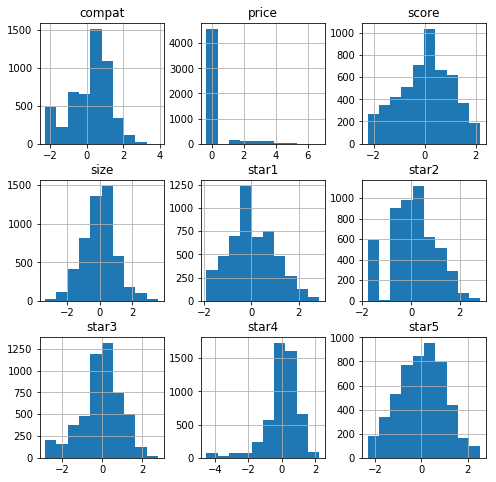

In [653]:
test_set_processed = test_set.copy()

test_set_processed[numeric_feat] = full_pipeline.fit_transform(test_set[numeric_feat])
test_set_processed[numeric_feat].hist(bins=10, figsize=(8,8))


test_predict = gbr_grid.best_estimator_.predict(test_set)

mean_absolute_error(test_label, test_predict)

In [655]:
test_predict[test_identity['title']=='Where Shadows Slumber']

array([787.43234331])

In [683]:
wss = test_set[test_identity['title']=='Where Shadows Slumber'].copy()

# wss['editor'] = True
wss['price'] = 0
wss['star']
gbr_grid.best_estimator_.predict(wss)


array([202.2650004])

In [666]:
wss

,compat,editor,iap,list_rank,price,score,size,age_12,age_17,age_4,...,star5,star4,star3,star2,star1,sup_family_sharing,sup_game_center,sup_game_controllers,sup_siri,sup_wallet
187663,9.0,0,0,0,2.99,4.5,513.5,1,0,0,...,77.0,10.0,5.0,5.0,4.0,1,0,0,0,0


In [668]:
test_label[test_identity['title']=='Where Shadows Slumber']

187663    175.0
Name: nrating, dtype: float64

In [684]:
test_predict = gbr_grid.best_estimator_.predict(test_set)


In [685]:
test_predict[test_identity['title']=='Where Shadows Slumber']

array([47.78676063])